In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [20]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [21]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

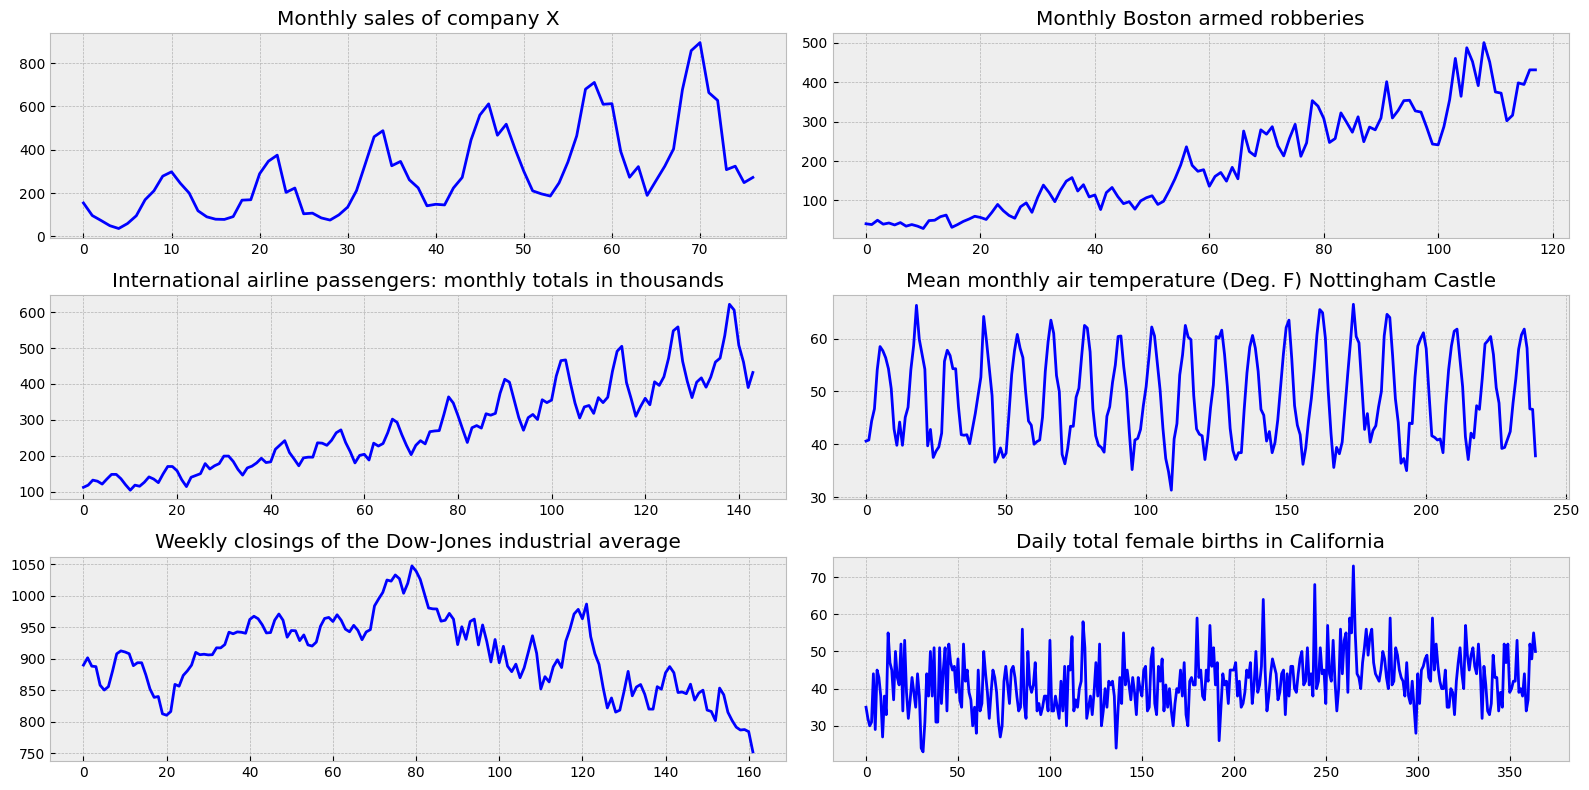

In [22]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Попробуем продиффиренцировать их всех и проверим.

In [32]:
stationary_series = {key: series.diff().dropna() for key, series in all_series.items()}

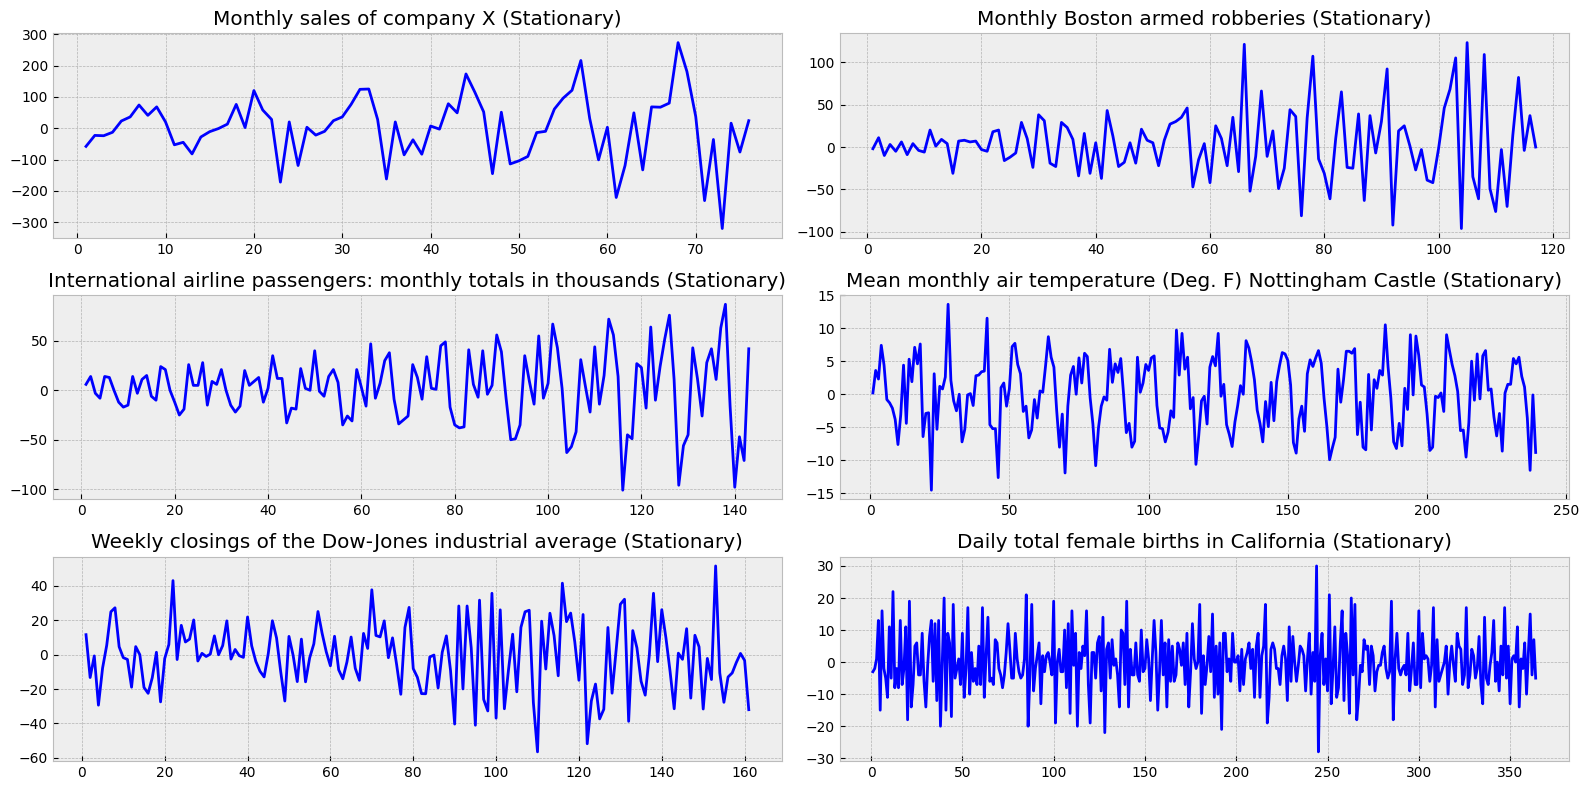

In [33]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(stationary_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        stationary_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(f"{key} (Stationary)")
        
    plt.tight_layout()
    plt.show()

In [39]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return


Monthly sales of company X (Original):
Results of Dickey-Fuller Test:
Test Statistic                 -2.587970
p-value                         0.095509
#Lags Used                     12.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64

Monthly Boston armed robberies (Original):
Results of Dickey-Fuller Test:
Test Statistic                -7.428564e+00
p-value                        6.450795e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64

International airline passengers: monthly totals in thousands (Original):
Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.0000

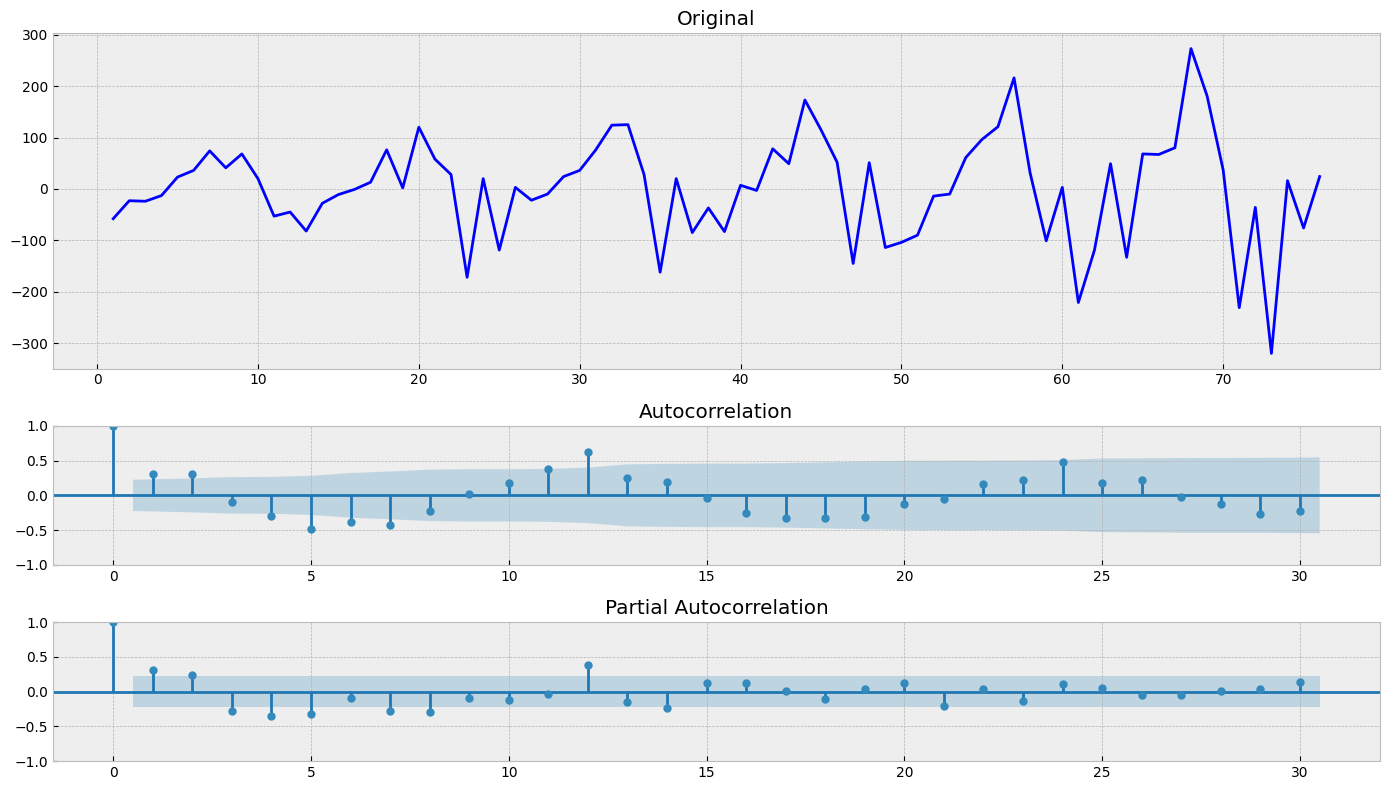

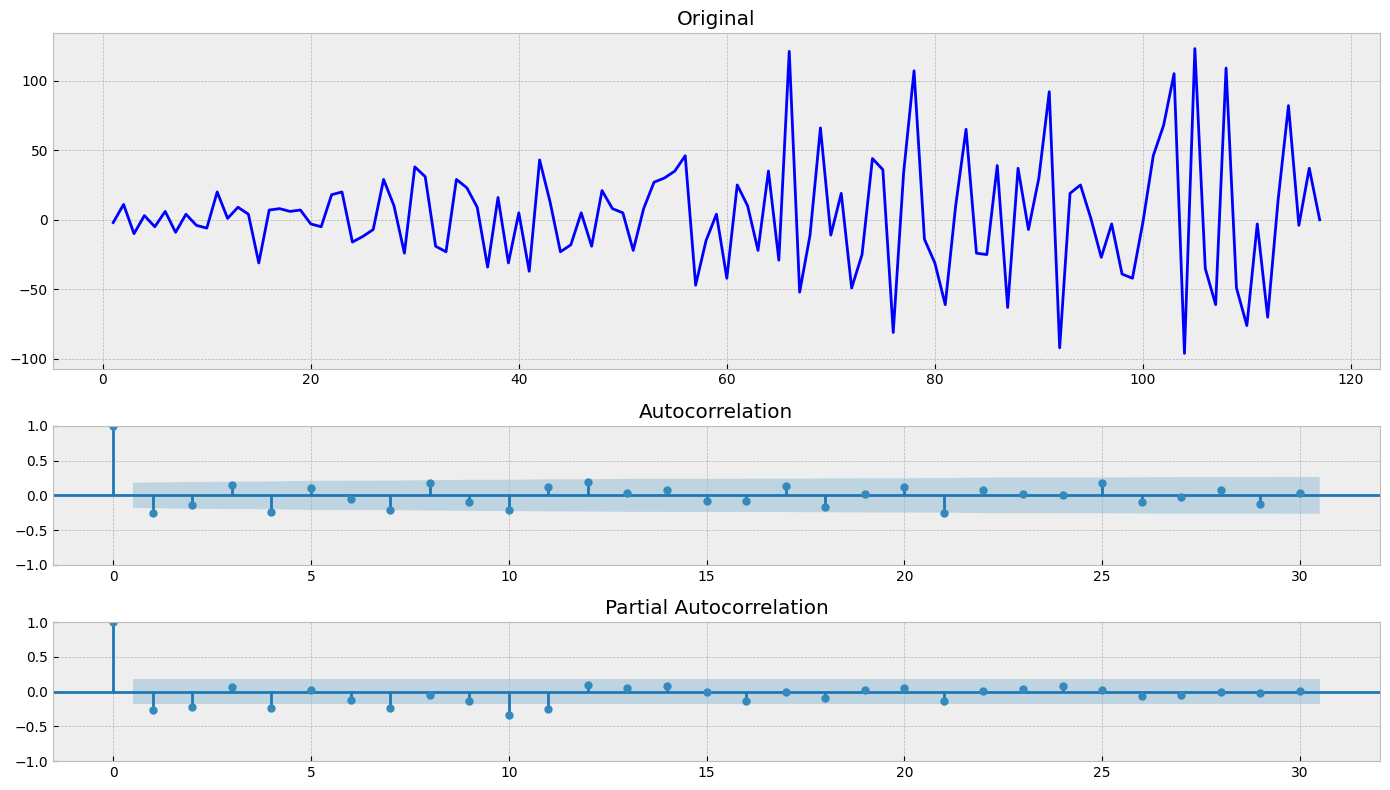

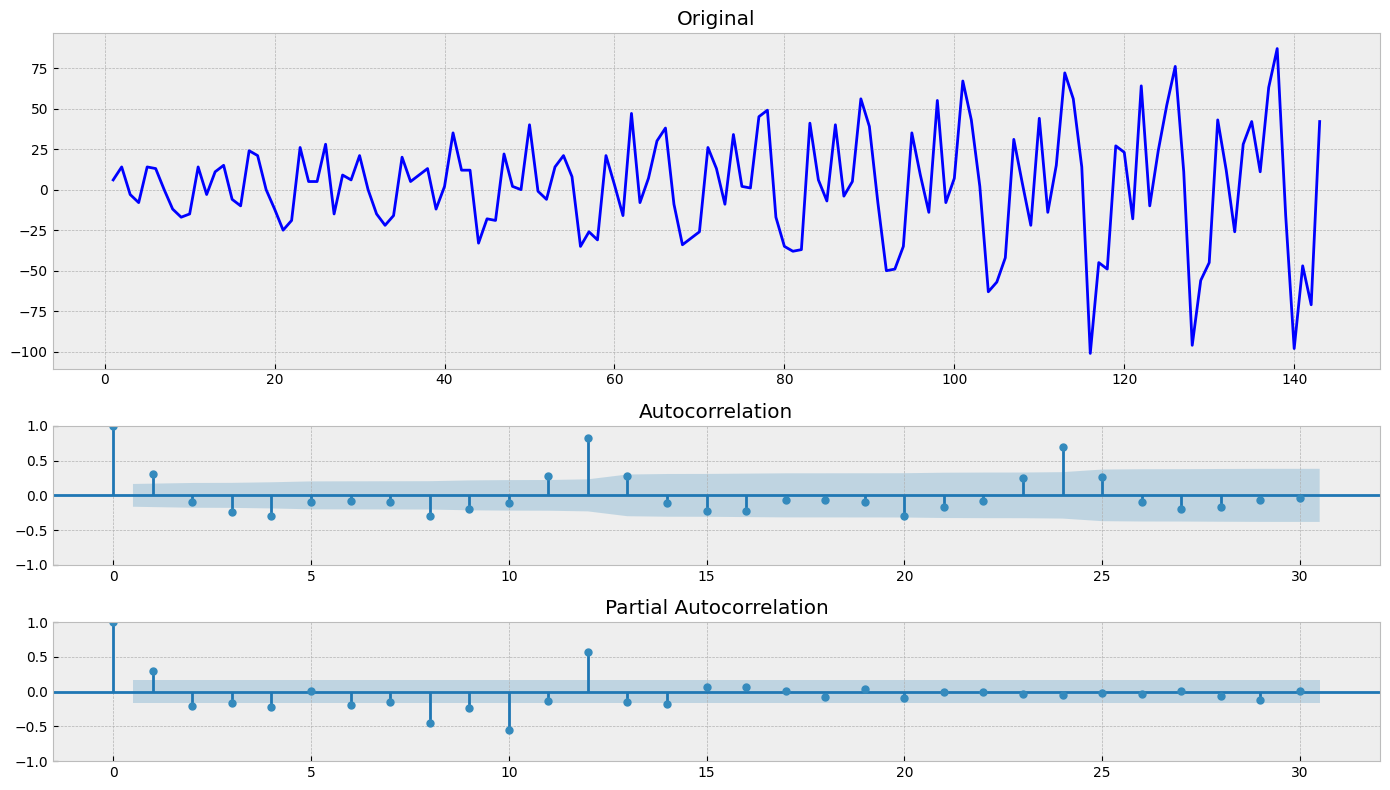

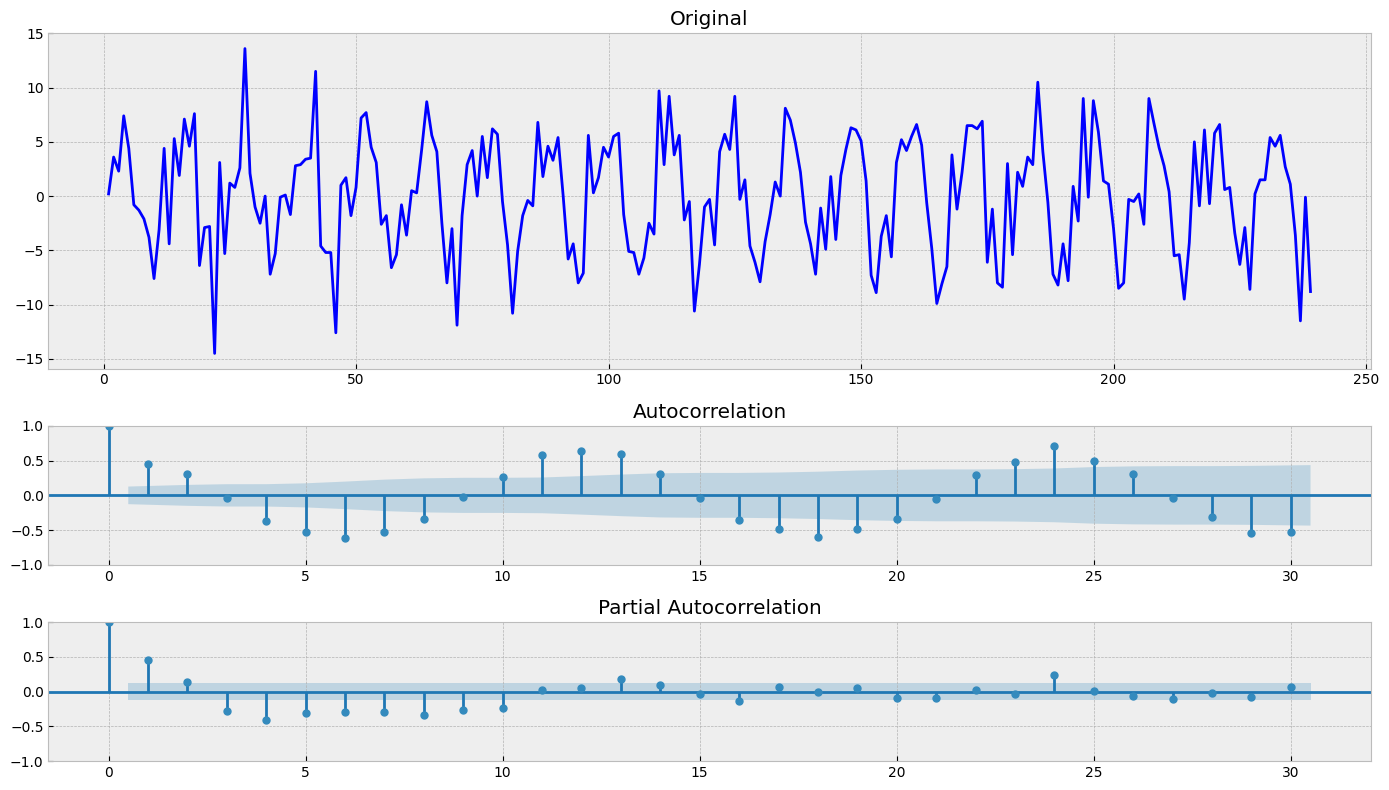

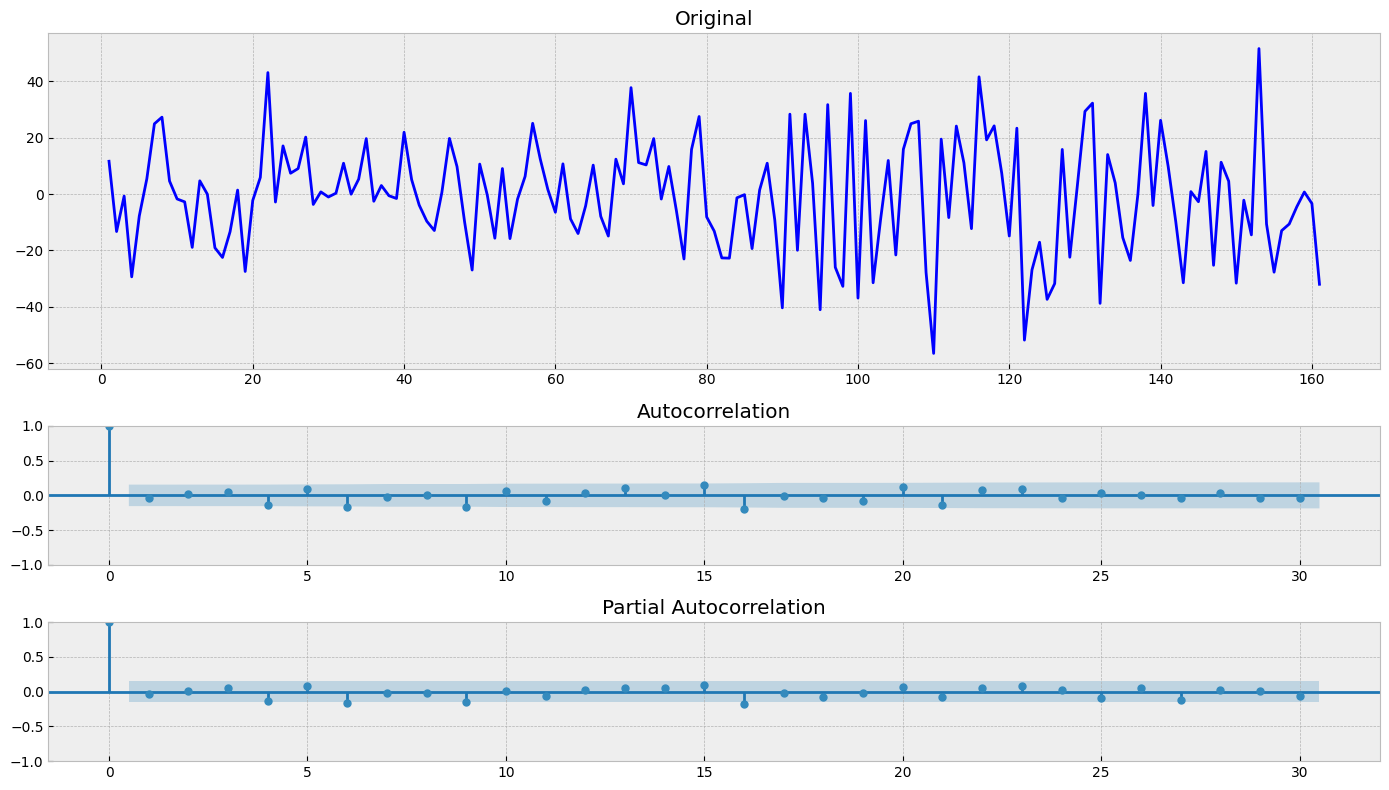

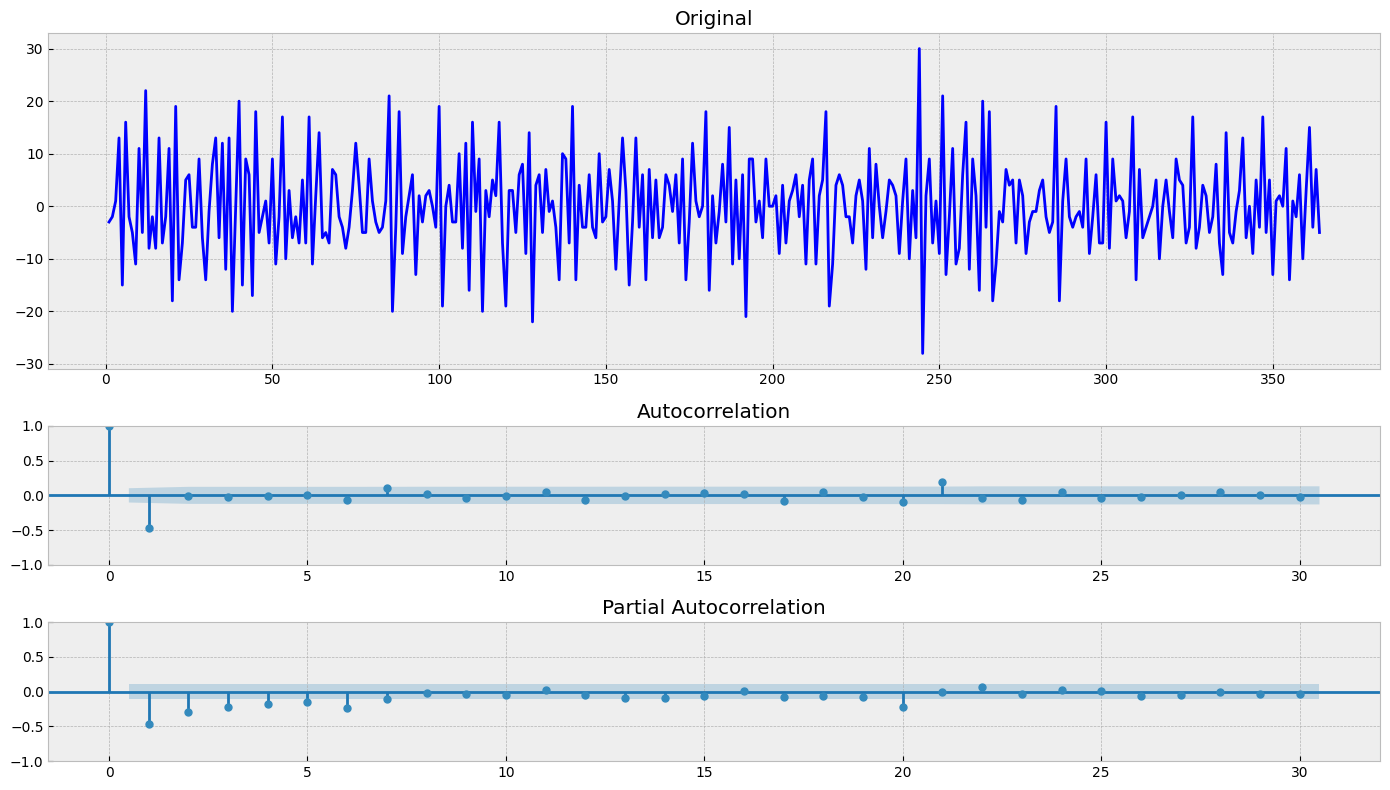

In [40]:
for key, series in stationary_series.items():
    print(f"\n{key} (Original):")
    tsplot(series, lags=30)

Все ряды, кроме 1 и 3 стационарные. По графику видно, что надо применить еще раз дифферинцирование с лагом 12. 

In [41]:
sales_of_company_x_diff = sales_of_company_x["Count"].diff(12).dropna()
airlines_passengers_diff = airlines_passengers["Count"].diff(12).dropna()


Monthly sales of company X (Differenced with lag 12):
Results of Dickey-Fuller Test:
Test Statistic                 -2.020925
p-value                         0.277474
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


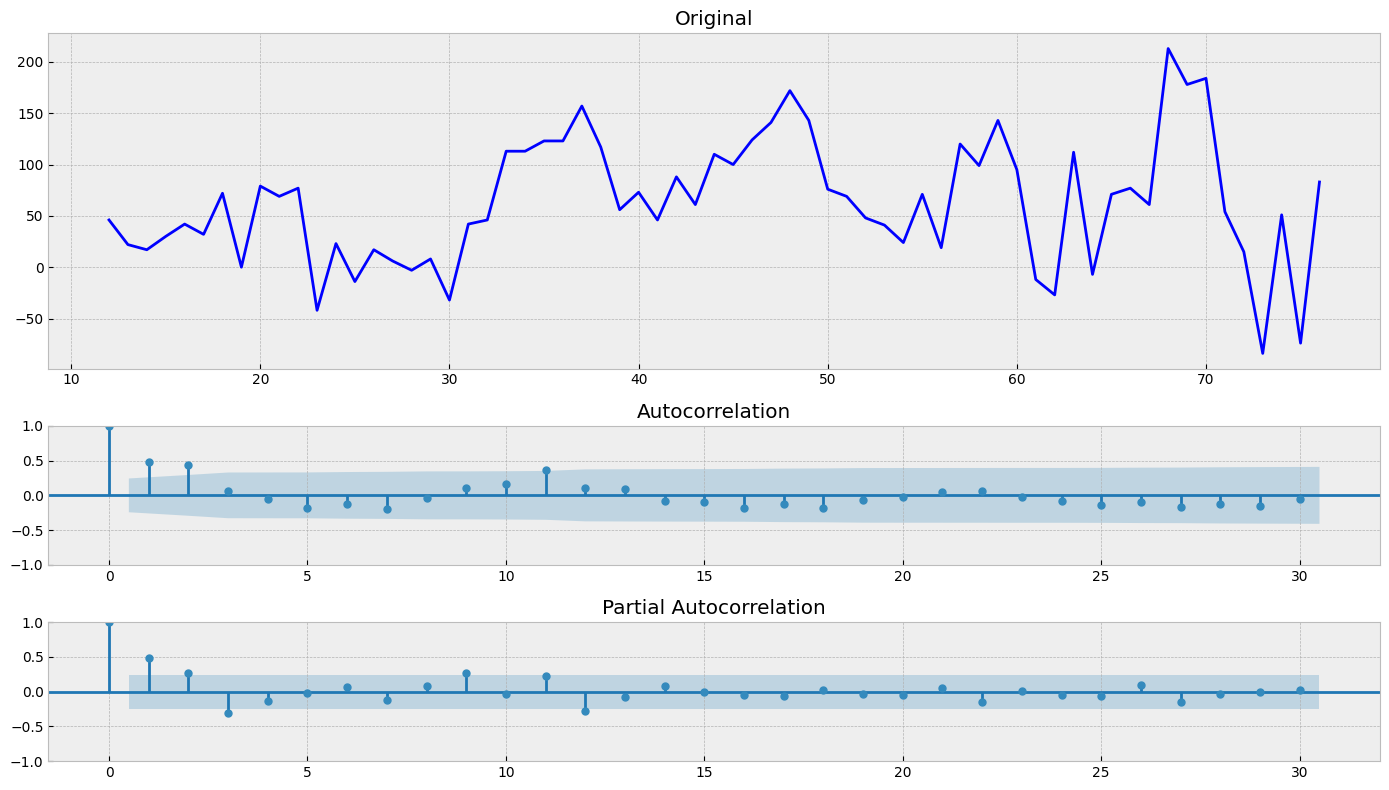

In [42]:
print("\nMonthly sales of company X (Differenced with lag 12):")
tsplot(sales_of_company_x_diff, lags=30)


International airline passengers: monthly totals in thousands (Differenced with lag 12):
Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


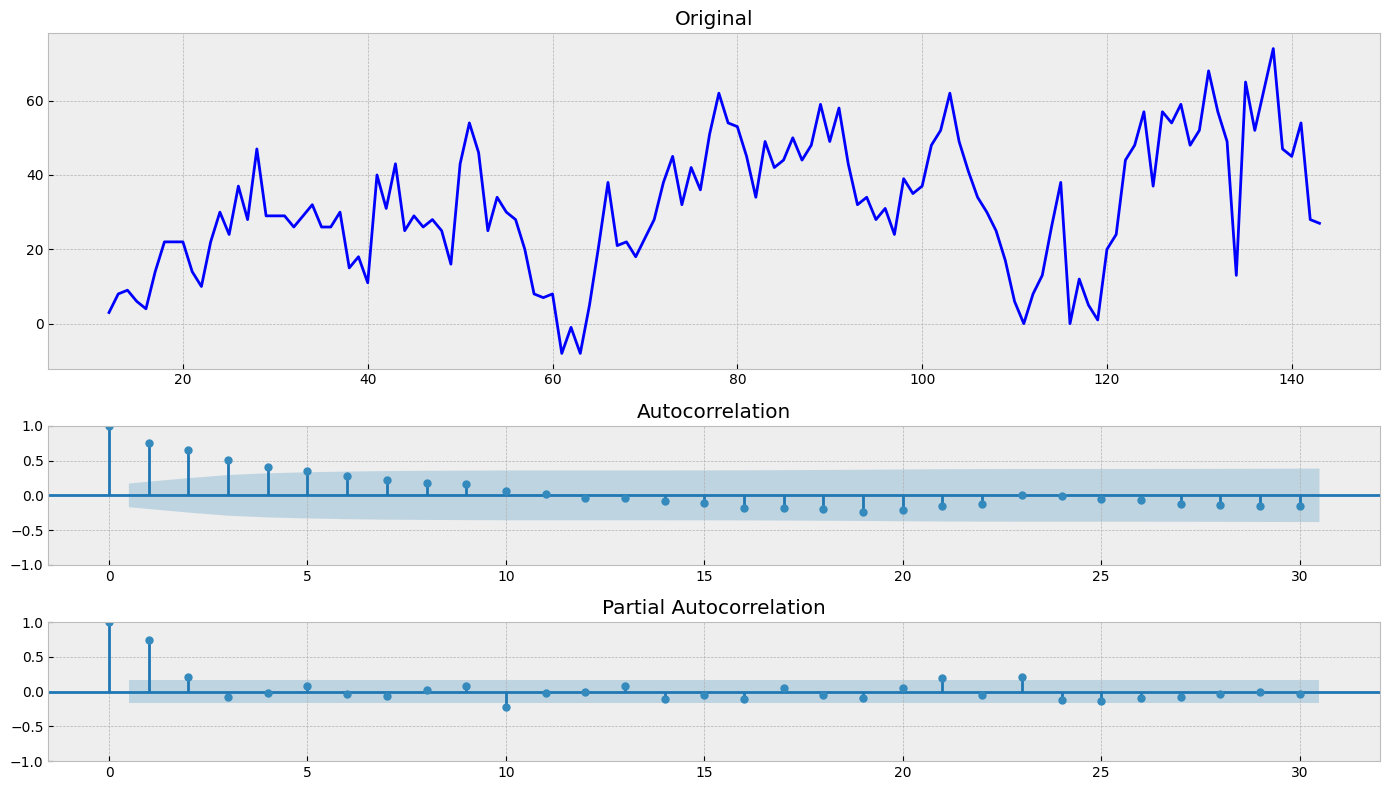

In [43]:
print("\nInternational airline passengers: monthly totals in thousands (Differenced with lag 12):")
tsplot(airlines_passengers_diff, lags=30)

Отлично теперь 3 ряд стал стационарным. Попробуем логарифмировать 1 ряд. Для избежании ошибки сначало логармфмируем.

In [52]:
sales_of_company_x_log = np.log(sales_of_company_x["Count"].replace(0, np.nan)).dropna()

In [53]:
sales_of_company_x_diff_log = sales_of_company_x_log.diff().dropna()
sales_of_company_x_diff_log = sales_of_company_x_log.diff(12).dropna()


Monthly sales of company X (Log and Differenced with lag 12):
Results of Dickey-Fuller Test:
Test Statistic                 -2.385128
p-value                         0.145978
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


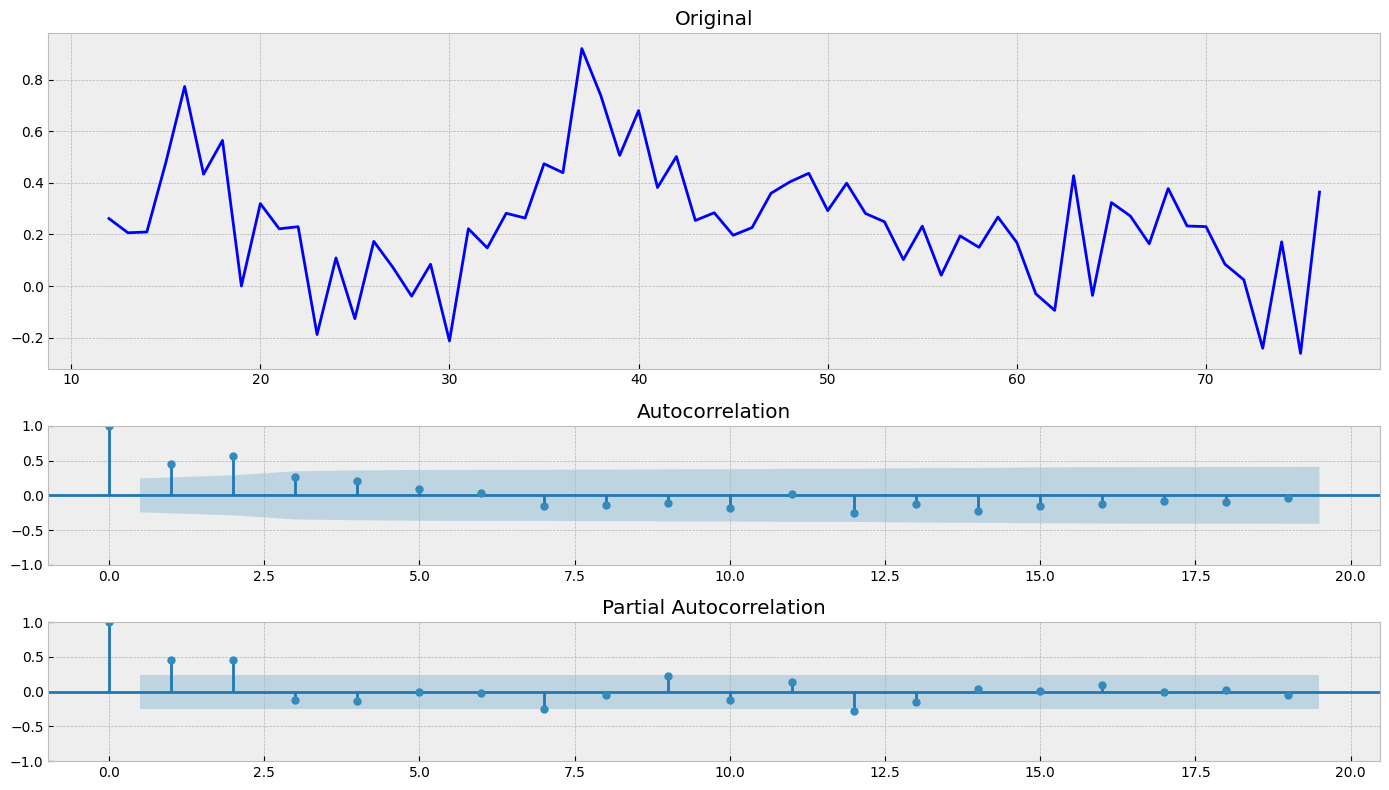

In [54]:
print("\nMonthly sales of company X (Log and Differenced with lag 12):")
tsplot(sales_of_company_x_diff_log)

In [55]:
sales_of_company_x_diff_log = boxcox(sales_of_company_x_diff_log, 0)

In [58]:
sales_of_company_x_diff_log = sales_of_company_x_diff_log[~np.isinf(sales_of_company_x_diff_log) & ~np.isnan(sales_of_company_x_diff_log)]

Results of Dickey-Fuller Test:
Test Statistic                 -3.306929
p-value                         0.014572
#Lags Used                      2.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


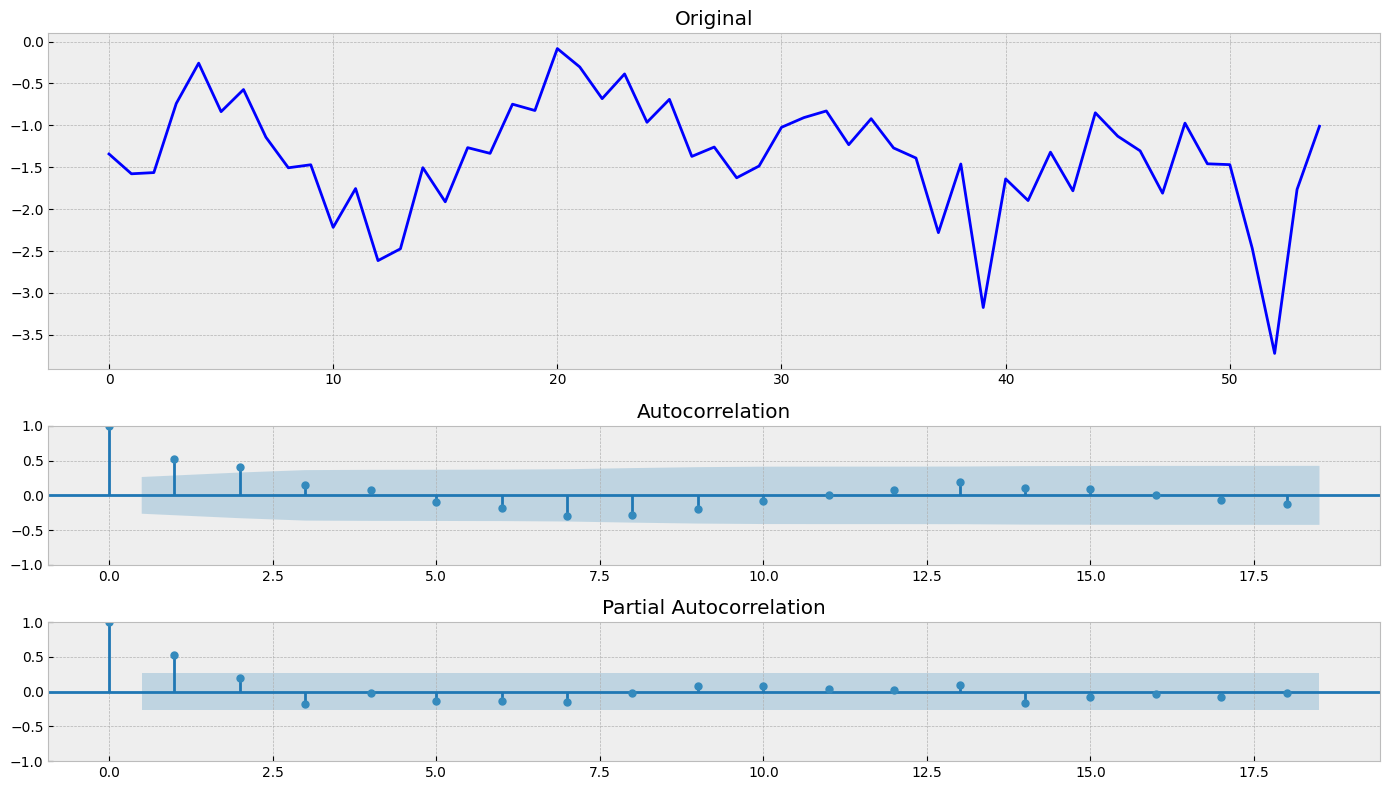

In [59]:
tsplot(sales_of_company_x_diff_log)

In [ ]:
Теперь временой ряд 1 тоже стационарный.